# fifa analysis: clean data
---

# context
This is an exercise i've created to practice analytics. I am using a dataset from kaggle.com that represents individual fifa players. My goal is to provide insights for a team manager from the data. I assume that the team manager wants to optimize for the most skilled team that brings the most money.
   
#### data
* Player personal attributes (Nationality, Club, Photo, Age, Value etc.)
* Player performance attributes (Overall, Potential, Aggression, Agility etc.)
* Player preferred position and ratings at all positions.

---
# summary
* remove duplicates
* convert strings through numerical values when appropriate,such as wage
* look at correlations to make sure the data distribution is realistic
---

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
players = pd.read_csv("CompleteDataset.csv",index_col='Unnamed: 0')
players.shape

/Users/nico/code/pydata-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(17981, 74)

In [20]:
#we need to rename the index otherwise when this data frame gets written to a file,it uses the old index name
players.index.name = 'index'

---
# remove duplicates

In [21]:
# are any players who appear twice actually in 2 different clubs?
# apparently not
clubs = players.groupby('Photo')['Club'].nunique()  > 1
clubs[clubs  == True]

Series([], Name: Club, dtype: bool)

In [22]:
#because of the above check, it's safe to remove duplicates
players.drop_duplicates(subset='Photo',inplace=True)
players.shape

(17929, 74)

---
# convert strings to floats

In [23]:
#convert the monies in Value and Wage columns to numbers
def convertMoney(money):
    money = money[1:]
    try:
        number = float(money[:-1])
    except:
        number = 0
    if money[-1] == 'M':
        return number * 1000000
    if money[-1] == 'K':
        return number * 1000
    else:
        return number
    
players['Value'] = players['Value'].apply(convertMoney)

players['Wage'] = players['Wage'].apply(convertMoney)

In [24]:
players.describe()

Age       Overall     Potential         Value           Wage  \
count  17929.000000  17929.000000  17929.000000  1.792900e+04   17929.000000   
mean      25.145407     66.213899     71.160912  2.357588e+06   11486.195549   
std        4.618983      6.969329      6.083949  5.335751e+06   23057.906406   
min       16.000000     46.000000     46.000000  0.000000e+00       0.000000   
25%       21.000000     62.000000     67.000000  3.000000e+05    2000.000000   
50%       25.000000     66.000000     71.000000  6.750000e+05    4000.000000   
75%       28.000000     71.000000     75.000000  2.000000e+06   12000.000000   
max       47.000000     94.000000     94.000000  1.230000e+08  565000.000000   

            Special           CAM            CB           CDM            CF  \
count  17929.000000  15905.000000  15905.000000  15905.000000  15905.000000   
mean    1593.254058     59.212826     55.529456     56.836718     58.991638   
std      271.833031      9.861741     12.185218     10.300524      9.908992   
min      728.000000     27.000000     25.000000     26.000000     27.000000   
25%     1448.000000     53.000000     45.000000     49.000000     53.000000   
50%     1633.000000     60.000000     57.000000     58.000000     60.000000   
75%     1785.000000     66.000000     65.000000     65.000000     66.000000   
max     2291.000000     92.000000     87.000000     85.000000     92.000000   

           ...                 RB           RCB           RCM           RDM  \
count      ...       15905.000000  15905.000000  15905.000000  15905.000000   
mean       ...          56.953097     55.529456     58.469538     56.836718   
std        ...           9.782626     12.185218      8.870525     10.300524   
min        ...          30.000000     25.000000     30.000000     26.000000   
25%        ...          50.000000     45.000000     53.000000     49.000000   
50%        ...          58.000000     57.000000     59.000000     58.000000   
75%        ...          64.000000     65.000000     65.000000     65.000000   
max        ...          84.000000     87.000000     87.000000     85.000000   

                 RF            RM            RS            RW           RWB  \
count  15905.000000  15905.000000  15905.000000  15905.000000  15905.000000   
mean      58.991638     60.020622     58.168941     59.321660     57.669789   
std        9.908992      9.331225      9.166438      9.960562      9.132719   
min       27.000000     28.000000     31.000000     26.000000     31.000000   
25%       53.000000     54.000000     52.000000     53.000000     51.000000   
50%       60.000000     61.000000     59.000000     60.000000     58.000000   
75%       66.000000     67.000000     65.000000     66.000000     64.000000   
max       92.000000     90.000000     92.000000     91.000000     84.000000   

                 ST  
count  15905.000000  
mean      58.168941  
std        9.166438  
min       31.000000  
25%       52.000000  
50%       59.000000  
75%       65.000000  
max       92.000000  

[8 rows x 33 columns]

### observations
* **age:** the middle 50% of players are between 21 and 28 years old. players play for a long time. does this experience make them better performers?
* **overall:** 
    * the average players Overall score is 66, with a standard deviation of 7. This does not seem to be a big spread.
    * the middle 50% of players overall score is between 62 and 71. This is a smaller spread.
    * Overall,just like the other score columns,looks like it's on a scale of 0 to 100. I don't think these are centered on any particular value intentionally. what tests of statistical significance would help explain the difference between a score of 66 and 67? **ask Paul**
* **potential:** I wonder what the Potential column is based on? 
* **value:** There is a very high standard deviation for Value. When this is graphed, it is exponential. I wonder if I need to put this through a log function when doing my analyses? **ask Paul**
* same question with wage
* **special:** I don't know what Special means. the source of the data does not explain. not worth taking time to inquire.
* **value and wage:** based on my research, the Value and Wage columns are weekly.

In [25]:
#do the datatypes of each column makes sense? they do not.all of these stats should be integers, but they are objects.
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17929 entries, 0 to 17980
Data columns (total 74 columns):
Name                   17929 non-null object
Age                    17929 non-null int64
Photo                  17929 non-null object
Nationality            17929 non-null object
Flag                   17929 non-null object
Overall                17929 non-null int64
Potential              17929 non-null int64
Club                   17681 non-null object
Club Logo              17929 non-null object
Value                  17929 non-null float64
Wage                   17929 non-null float64
Special                17929 non-null int64
Acceleration           17929 non-null object
Aggression             17929 non-null object
Agility                17929 non-null object
Balance                17929 non-null object
Ball control           17929 non-null object
Composure              17929 non-null object
Crossing               17929 non-null object
Curve                  17929 non-null 

---
# view correlations

In [26]:
players.columns

Index(['Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall', 'Potential',
       'Club', 'Club Logo', 'Value', 'Wage', 'Special', 'Acceleration',
       'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure',
       'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy',
       'GK diving', 'GK handling', 'GK kicking', 'GK positioning',
       'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping',
       'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning',
       'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
       'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision',
       'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID', 'LAM', 'LB', 'LCB',
       'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'Preferred Positions',
       'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

In [27]:
# pick out the primary columns to check their correlations
primary = players[['Overall','Potential','Value','Wage','Age']]

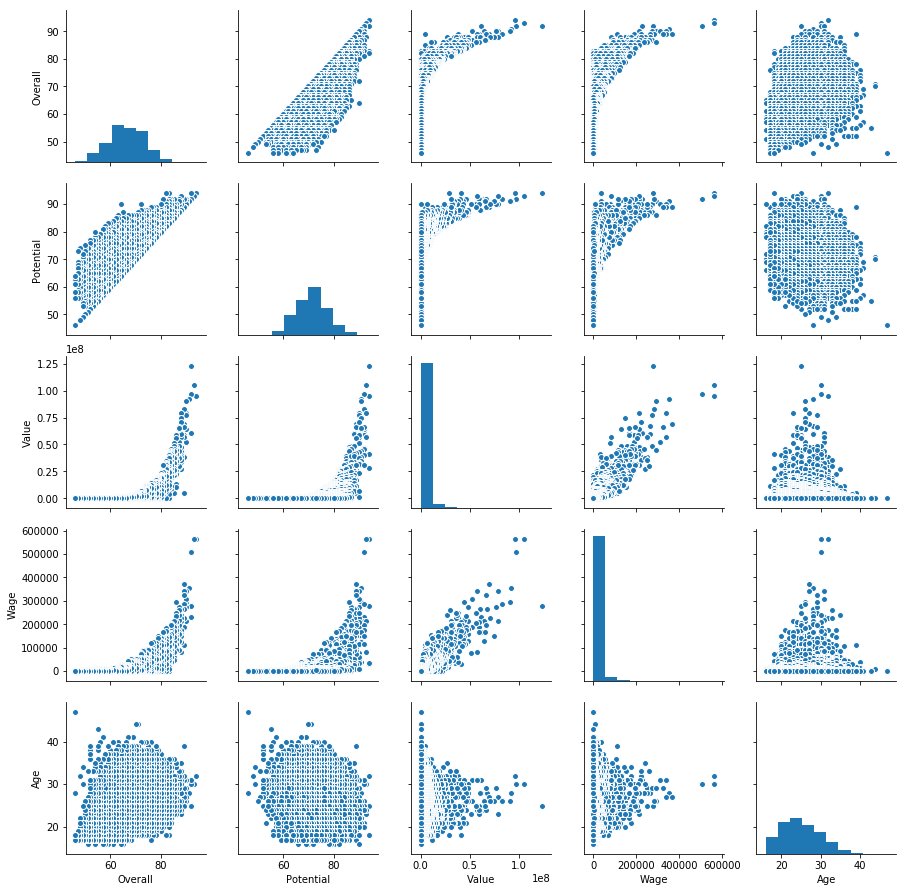

In [28]:
sns.pairplot(primary)

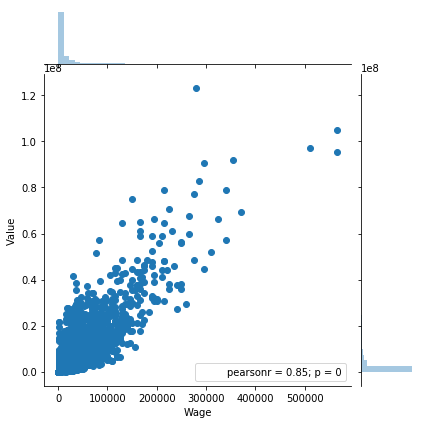

In [29]:
#what is the relation between wage and value? 
#strong correlation
sns.jointplot(x='Wage',y='Value',data=players)

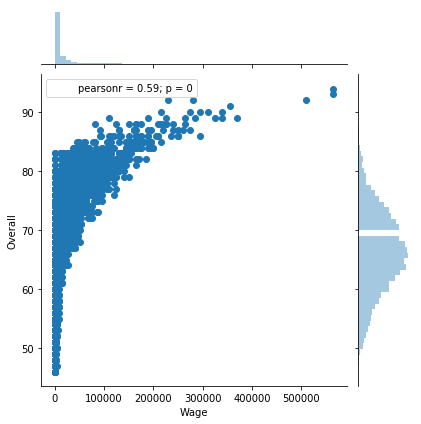

In [30]:
#how strong is the correlation between wage and overall skill?
#there is a correlation of 0.59 - I wonder how this compares to other industries?t
sns.jointplot(x='Wage',y='Overall',data=players)

In [31]:
#write to external file
players.to_csv('CompleteDataset_cleaned.csv')